In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import numpy

from IPython.display import Image
from tqdm.notebook import tqdm
from math import *


In [2]:
# Set dataset and model

# Dataset
dataset = torchvision.datasets.CIFAR10

# Pre-trained models of ViT: 
# torchvision.models.vit_b_16/vit_b_32/vit_l_16/vit_l_32
from torchvision.models import vit_b_16
model = vit_b_16(pretrained=True)

model_filename = "cifar10-vitb16"

warmup_epoch = 3
num_epoch = 10

lr_warmup = 3e-4
lr_base = 3e-3
lr_min = 3e-4

device = "cuda:3" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224)
])
train_set = dataset("./data", train = True, download = True, transform=transform)
test_set = dataset("./data", train = False, download = True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 224, 224])


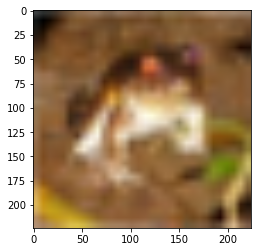

In [4]:
print(train_set[0][0].shape)
plt.imshow(train_set[0][0].permute(1,2,0).numpy()[:,:,::])
plt.show()

In [5]:
in_features = model.heads[0].in_features
in_features

768

In [6]:
model.heads = nn.Linear(in_features,len(train_set.classes)) # set in_features and out_features
model.train()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [7]:
# Freeze other layers unless it is self_attention or mlp_head
for name, param in model.named_parameters():
    if ('self_attention' in name) or ('head' in name):
        print("Unfreeze " + name)
        param.requires_grad = True
    else:
        print("Freeze " + name)
        param.requires_grad = False

Freeze class_token
Freeze conv_proj.weight
Freeze conv_proj.bias
Freeze encoder.pos_embedding
Freeze encoder.layers.encoder_layer_0.ln_1.weight
Freeze encoder.layers.encoder_layer_0.ln_1.bias
Unfreeze encoder.layers.encoder_layer_0.self_attention.in_proj_weight
Unfreeze encoder.layers.encoder_layer_0.self_attention.in_proj_bias
Unfreeze encoder.layers.encoder_layer_0.self_attention.out_proj.weight
Unfreeze encoder.layers.encoder_layer_0.self_attention.out_proj.bias
Freeze encoder.layers.encoder_layer_0.ln_2.weight
Freeze encoder.layers.encoder_layer_0.ln_2.bias
Freeze encoder.layers.encoder_layer_0.mlp.linear_1.weight
Freeze encoder.layers.encoder_layer_0.mlp.linear_1.bias
Freeze encoder.layers.encoder_layer_0.mlp.linear_2.weight
Freeze encoder.layers.encoder_layer_0.mlp.linear_2.bias
Freeze encoder.layers.encoder_layer_1.ln_1.weight
Freeze encoder.layers.encoder_layer_1.ln_1.bias
Unfreeze encoder.layers.encoder_layer_1.self_attention.in_proj_weight
Unfreeze encoder.layers.encoder_laye

In [8]:
# Reading whole dataloader into memory can improve the speed of training
train_loader = list(train_loader)

In [9]:
# model.load_state_dict(torch.load("model/" + model_filename))
# loss_function = nn.CrossEntropyLoss()
# trial = Trial(model, optimiser2, loss_function, metrics=['loss', 'accuracy']).to(device)
# trial.with_generators(train_loader, test_generator=test_loader)

In [10]:
loss_function = nn.CrossEntropyLoss()

In [11]:
lr = lr_base
def adjust_learning_rate(optimizer, current_epoch, max_epoch, lr_min=lr_min, lr_max=lr_base, warmup=True):
    if current_epoch < warmup_epoch:
        lr = lr_max * (current_epoch+1) / (warmup_epoch+1)
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("Learning rate is set to "+str(lr))

optimiser = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=lr,
                      momentum=0.9) #only optimse non-frozen layers
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [12]:
results = []

for epoch in range(warmup_epoch+num_epoch):
    running_loss = 0
    train_acc = 0
    
    adjust_learning_rate(optimizer=optimiser,
                        current_epoch=epoch,
                        max_epoch=warmup_epoch+num_epoch)
    with tqdm(train_loader, desc='Train(epoch'+str(epoch)+')') as t:
        total = 0
        correct = 0
        for data in t:
            model.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimiser.step()
            
            pred = torch.argmax(F.softmax(outputs), dim=1)
            total += len(labels)
            correct += sum(pred == labels)
            
        train_acc = (100.0 * correct) / total

        t.set_postfix(running_loss=running_loss,
                      runing_acc=train_acc)
            
    print("epoch %d/%d:(tr)loss=%.4f" % (epoch, warmup_epoch+num_epoch, running_loss))
    print("epoch %d/%d:(tr)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, train_acc))
    
    test_running_loss = 0
    test_acc = 0

    with tqdm(test_loader, desc='test'+str(epoch)) as t:
        with torch.no_grad():
            total = 0
            correct = 0
            for data in t:
                model.eval()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)
                test_running_loss += loss.item()
                            
                pred = torch.argmax(F.softmax(outputs), dim=1)
                total += len(labels)
                correct += sum(pred == labels)
            test_acc = (100.0 * correct) / total

            t.set_postfix(running_loss=test_running_loss,
                          runing_acc=test_acc)

    print("epoch %d/%d:(te)loss=%.4f" % (epoch, warmup_epoch+num_epoch, test_running_loss))
    print("epoch %d/%d:(te)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, test_acc))
          
    results.append({'running_loss':running_loss,
                   'train_acc':train_acc,
                   'test_running_loss':test_running_loss,
                   'test_acc':test_acc})


Learning rate is set to 0.00075


Train(epoch0):   0%|          | 0/782 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/13:(tr)loss=238.1554
epoch 0/13:(tr)acc=92.1280%


test0:   0%|          | 0/157 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/13:(te)loss=18.0683
epoch 0/13:(te)acc=96.2800%
Learning rate is set to 0.0015


Train(epoch1):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 1/13:(tr)loss=68.5736
epoch 1/13:(tr)acc=97.2080%


test1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1/13:(te)loss=13.8496
epoch 1/13:(te)acc=97.0000%
Learning rate is set to 0.0022500000000000003


Train(epoch2):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 2/13:(tr)loss=39.9937
epoch 2/13:(tr)acc=98.4140%


test2:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 2/13:(te)loss=13.9301
epoch 2/13:(te)acc=97.0000%
Learning rate is set to 0.003


Train(epoch3):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 3/13:(tr)loss=27.0647
epoch 3/13:(tr)acc=98.8580%


test3:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 3/13:(te)loss=14.8753
epoch 3/13:(te)acc=97.0300%
Learning rate is set to 0.0029339262969984574


Train(epoch4):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 4/13:(tr)loss=17.8953
epoch 4/13:(tr)acc=99.2660%


test4:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 4/13:(te)loss=14.8209
epoch 4/13:(te)acc=97.2100%
Learning rate is set to 0.0027421729424061793


Train(epoch5):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 5/13:(tr)loss=9.6998
epoch 5/13:(tr)acc=99.6240%


test5:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 5/13:(te)loss=14.9958
epoch 5/13:(te)acc=97.4400%
Learning rate is set to 0.002443510090594839


Train(epoch6):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 6/13:(tr)loss=4.1889
epoch 6/13:(tr)acc=99.8800%


test6:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 6/13:(te)loss=14.8891
epoch 6/13:(te)acc=97.6900%
Learning rate is set to 0.002067172942406179


Train(epoch7):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 7/13:(tr)loss=1.5100
epoch 7/13:(tr)acc=99.9760%


test7:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 7/13:(te)loss=13.9875
epoch 7/13:(te)acc=97.8500%
Learning rate is set to 0.00165


Train(epoch8):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 8/13:(tr)loss=0.7800
epoch 8/13:(tr)acc=99.9920%


test8:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 8/13:(te)loss=14.4983
epoch 8/13:(te)acc=97.9000%
Learning rate is set to 0.0012328270575938211


Train(epoch9):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 9/13:(tr)loss=0.5413
epoch 9/13:(tr)acc=99.9980%


test9:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 9/13:(te)loss=14.4993
epoch 9/13:(te)acc=97.9300%
Learning rate is set to 0.0008564899094051614


Train(epoch10):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 10/13:(tr)loss=0.4734
epoch 10/13:(tr)acc=99.9980%


test10:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 10/13:(te)loss=14.5546
epoch 10/13:(te)acc=97.9600%
Learning rate is set to 0.0005578270575938211


Train(epoch11):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 11/13:(tr)loss=0.4409
epoch 11/13:(tr)acc=99.9980%


test11:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 11/13:(te)loss=14.5730
epoch 11/13:(te)acc=97.9700%
Learning rate is set to 0.0003660737030015427


Train(epoch12):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 12/13:(tr)loss=0.4225
epoch 12/13:(tr)acc=99.9980%


test12:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 12/13:(te)loss=14.6047
epoch 12/13:(te)acc=97.9700%


In [13]:
results

[{'running_loss': 238.1554025169462,
  'train_acc': tensor(92.1280, device='cuda:3'),
  'test_running_loss': 18.068289378657937,
  'test_acc': tensor(96.2800, device='cuda:3')},
 {'running_loss': 68.57361521851271,
  'train_acc': tensor(97.2080, device='cuda:3'),
  'test_running_loss': 13.84962506312877,
  'test_acc': tensor(97., device='cuda:3')},
 {'running_loss': 39.9937285380438,
  'train_acc': tensor(98.4140, device='cuda:3'),
  'test_running_loss': 13.930068330373615,
  'test_acc': tensor(97., device='cuda:3')},
 {'running_loss': 27.064664408448152,
  'train_acc': tensor(98.8580, device='cuda:3'),
  'test_running_loss': 14.875261537963524,
  'test_acc': tensor(97.0300, device='cuda:3')},
 {'running_loss': 17.895278319658246,
  'train_acc': tensor(99.2660, device='cuda:3'),
  'test_running_loss': 14.820882113883272,
  'test_acc': tensor(97.2100, device='cuda:3')},
 {'running_loss': 9.69977117254166,
  'train_acc': tensor(99.6240, device='cuda:3'),
  'test_running_loss': 14.9957915

In [14]:
torch.save(model.state_dict(), "model/" + model_filename)

In [19]:
train_loss_list = []
train_acc_list = []
for result in results:
    train_loss_list.append(result["running_loss"])
    train_acc_list.append(torch.Tensor.cpu(result["train_acc"]))

In [20]:
test_loss_list = []
test_acc_list = []
for result in results:
    test_loss_list.append(result["test_running_loss"])
    test_acc_list.append(torch.Tensor.cpu(result["test_acc"]))

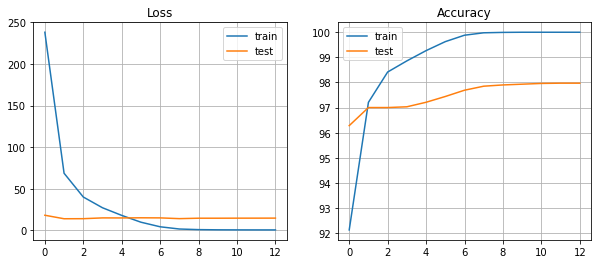

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].legend(['train','test'])
ax[0].grid()
ax[0].set_title("Loss")

ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].legend(['train','test'])
ax[1].grid()
ax[1].set_title("Accuracy")
plt.show()